# Wstęp do multimediów - Laboratorium 5

Statystyczne właściwości obrazów

Bartłomiej Krawczyk
310774

Grupa 103

In [154]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image, display

## Pliki

In [155]:
IMAGE_DIR = './images/'
IMAGE_COL = IMAGE_DIR + 'latarnia2_col.png'
IMAGE_MONO = IMAGE_DIR + 'latarnia2_mono.png'

In [156]:
OUTPUT_IMAGE_FILE_PATH = './output/output.png'

def show_image(image, name=None):
    if name:
        print(name)
    
    if (image.dtype == np.float32) or (image.dtype == np.float64):
        image = image / 255
    if image.dtype == np.int16:
        image = ((image + 255) // 2).astype(np.uint8)
    cv2.imwrite(OUTPUT_IMAGE_FILE_PATH, image)
    display(Image(filename=OUTPUT_IMAGE_FILE_PATH))


W sprawozdaniu należy zamieścić wyniki uzyskane dla obrazu testowego, wybranego na podstawie numeru indeksu w następujący sposób: 

`numer_obrazu = numer_indeksu % liczba_obrazow`

gdzie  numer  obrazu  wskazuje  pozycję pliku na posortowanej alfabetycznie liście nazw plików  testowych (pozycje numerowane od 0, tak jak elementy list w Pythonie), a % oznacza operację modulo). 

## Wylosowany Obraz

In [157]:
image_number = 310774 % 36
print(f'{image_number = }')

image_number = 22


Obraz o numerze 22 to `latarnia2`.

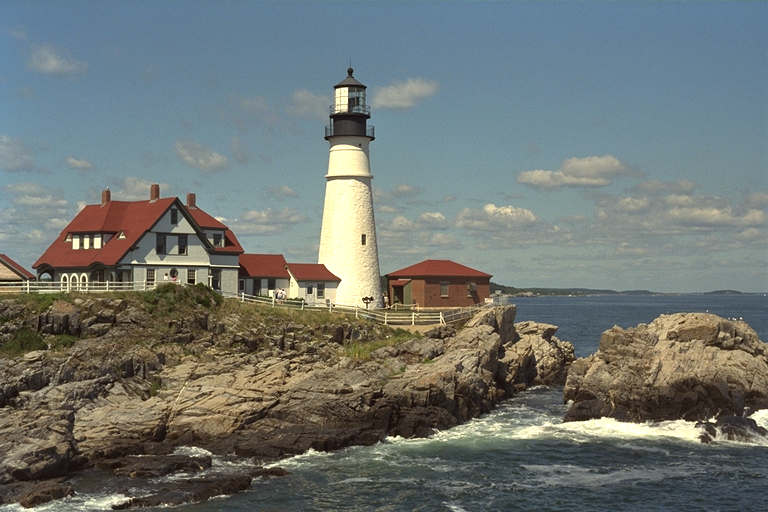

In [158]:
image_col = cv2.imread(IMAGE_COL, cv2.IMREAD_UNCHANGED)
show_image(image_col)

# Obraz Monochromatyczny

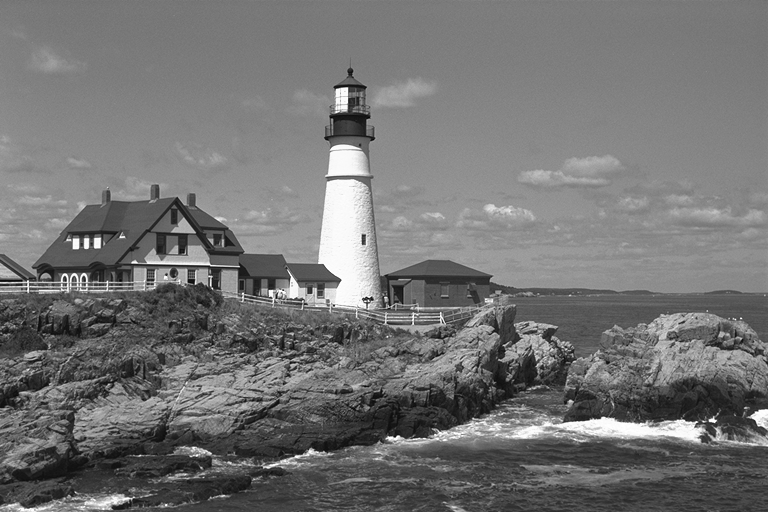

In [159]:
image_mono = cv2.imread(IMAGE_MONO, cv2.IMREAD_UNCHANGED)
show_image(image_mono)

- Obliczyć  przepływność  (liczbę  bitów  przypadającą  na  jeden  piksel)  dla  obrazu  skompresowanego koderem PNG (obraz wejściowy). 

In [160]:
def calculate_bitrate(image_name: str) -> float:
    """
    Obliczenie średniej bitowej dla pliku .png
    os.stat() podaje rozmiar pliku w bajtach, a potrzebny jest w bitach (-> '8*')
    """
    image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    return 8*os.stat(image_name).st_size / (image.shape[0]*image.shape[1])
    
bitrate = calculate_bitrate(IMAGE_MONO)
print(f"bitrate: {bitrate:.4f}")

bitrate: 5.0608


- Obliczyć entropię obrazu i porównać ją z wyliczoną przepływnością. Czy przepływność mniejsza od entropii oznacza, że zależność: lśr ≥ H jest nieprawdziwa?

In [161]:
def generate_histogram(image, size):
    """
    cv2.calcHist() zwraca histogram w postaci tablicy 2D,
    do dalszego przetwarzania wygodniejsza może być tablica jednowymiarowa -> flatten().
    """
    hist = cv2.calcHist([image], [0], None, [size], [0, size])
    hist = hist.flatten()
    return hist
    
def calculate_entropy(hist):
    """
    Obliczanie entropii
    """
    hist_sum = hist.sum()
    if hist_sum != 0:
        pdf = hist / hist_sum  # normalizacja histogramu -> rozkład prawdopodobieństwa
        entropy = -sum([x*np.log2(x) for x in pdf if x != 0])
        return entropy


H_image = calculate_entropy(generate_histogram(image_mono, 256))
print(f"H(image) = {H_image:.4f}")

H(image) = 7.0398


> Czy przepływność mniejsza od entropii oznacza, że zależność: lśr ≥ H jest nieprawdziwa?

Nie, zależność lśr ≥ H jest prawdziwa przy założeniu niezależności wartości kodowanych.

Jednakże kodowanie w obrazie PNG wykorzystuje kodowanie słownikowe LZSS, które uwzględnia korelację wartości.

wartości kodowane są zależne => prawdopodobieństwo symboli złożonych **może nie być** iloczynem prowdopodobieństw symboli go tworzących

In [162]:
def printi(img, img_title="image"):
    """ Pomocnicza funkcja do wypisania informacji o obrazie. """
    print(f"{img_title}, wymiary: {img.shape}, typ danych: {img.dtype}, wartości: {img.min()} - {img.max()}")

- Wyznaczyć obraz różnicowy w taki sposób, że wartość każdego piksela zastępowana jest różnicą pomiędzy wartością tego piksela a wartością jego lewego sąsiada (kodowanie różnicowe / predykcyjne). Dla pierwszego piksela w linii należy przyjąć wartość sąsiada równą 127 (środkowa wartość przedziału zmienności wartości pikseli).

- Wyświetlić obraz różnicowy.

**`Uwaga`**: należy pamiętać, że wartości pikseli w obrazie różnicowym są z zakresu [-255; 255]! 

image_hdiff, wymiary: (512, 768), typ danych: int16, wartości: -190 - 191


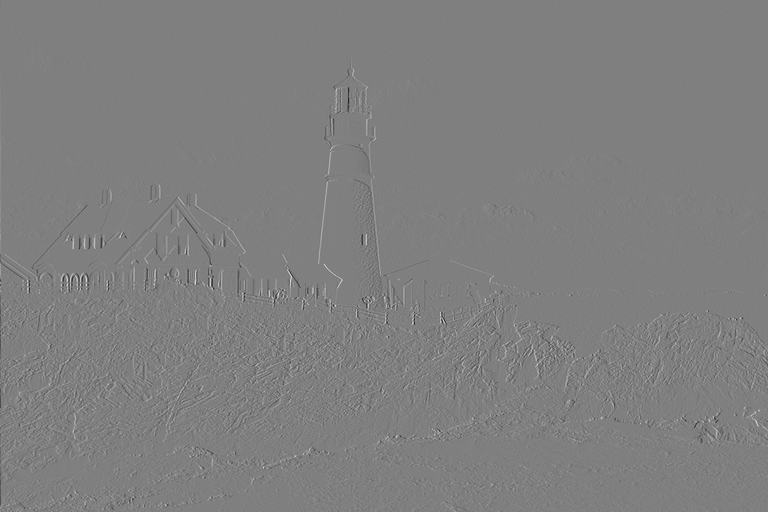

In [163]:
def differential_image(image):
    """
    Predykcja w kierunku poziomym:
    od wartości danego piksela odejmowana jest wartość piksela z lewej strony - 'lewego sąsiada' (operacje na kolumnach).
    Operację taką można wykonać dla pikseli leżących w drugiej i kolejnych kolumnach obrazu, z pominięciem skrajnie lewej kolumny.
    """
    img_tmp1 = image[:,
                    1:]  # wszystkie wiersze (':'), kolumny od 'pierwszej' do ostatniej ('1:')
    # wszystkie wiersze, kolumny od 'zerowej' do przedostatniej (':-1')
    img_tmp2 = image[:, :-1]

    """
    W wyniku odejmowania pojawią się wartości ujemne - zakres wartości pikseli w obrazie różnicowym to będzie [-255, 255],
    dlatego trzeba zmienić typ wartości pikseli, żeby zakres wartości nie ograniczał się do [0, 255];
    może to być np. cv2.CV_16S (odpowiednio np.int16 w NumPy), żeby pozostać w domenie liczb całkowitych.
    """
    image_hdiff = cv2.addWeighted(img_tmp1, 1, img_tmp2, -1, 0, dtype=cv2.CV_16S)
    """
    image_hdiff ma o jedną kolumnę mniej - dla skrajnie lewej kolumny nie było danych do odejmowania,
    kolumnę tę można potraktować oddzielnie i 'połączyć' wyniki.
    """
    image_hdiff_0 = cv2.addWeighted(
        image[:, 0], 1, 0, 0, -127, dtype=cv2.CV_16S)  # od 'zerowej' kolumny obrazu oryginalnego odejmowana stała wartość '127'
    # połączenie tablic w kierunku poziomym, czyli 'kolumna za kolumną'
    image_hdiff = np.hstack((image_hdiff_0, image_hdiff))

    return image_hdiff

image_hdiff = differential_image(image_mono)

printi(image_hdiff, "image_hdiff")
show_image(image_hdiff)

- Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.

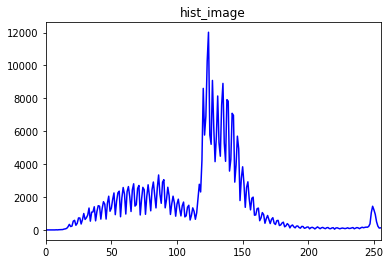

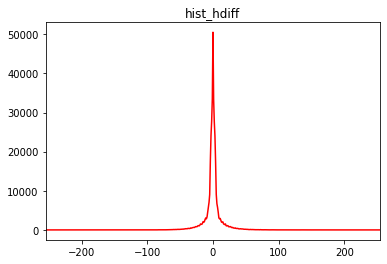

In [164]:
""" Entropia dla obrazów różnicowych """

"""
cv2.calcHist() wymaga danych w formacie liczb całkowitych bez znaku (8- lub 16-bitowych) lub 32-bitowych liczb rzeczywistych,
dlatego wartości pikseli są przesuwane z zakresu [-255, 255] do [0, 510] (-> '+255')
oraz konwertowane na typ np.uint16 (-> astype()).
"""

hist_image = generate_histogram(image_mono, 256)

image_tmp = (image_hdiff+255).astype(np.uint16)
hist_hdiff = generate_histogram(image_tmp, 511)

""" Wyświetlenie histogramów z wykorzystaniem matplotlib.pyplot """
plt.figure()
plt.plot(hist_image, color="blue")
plt.title("hist_image")
plt.xlim([0, 255])
plt.show()

# jawne podane wartości 'x' i 'y', żeby zmienić opisy na osi poziomej
plt.plot(np.arange(-255, 256, 1), hist_hdiff, color="red")
plt.title("hist_hdiff")
plt.xlim([-255, 255])
plt.show()

> Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.   

Histogram obrazu różnicowego jest skupiony blisko wartości 0, oznacza to, że wartości pikseli blisko siebie (różnica "lewych sąsiadów" od wartości piksela) generalnie nie różnią się za bardzo.

Histogram obrazu oryginalnego jest bardziej rozproszony po całym spektrum, a nie skupiony wokół jednego punktu.

- Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.  

In [165]:
print(f"H(image_mono) = {H_image:.4f}")
H_hdiff = calculate_entropy(hist_hdiff)
print(f"H(hdiff) = {H_hdiff:.4f}")

H(image_mono) = 7.0398
H(hdiff) = 5.0365


> Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.  

Entropia obrazu oryginalnego jest wyższa niż entropia obrazu różnicowego.

W obrazie różnicowym prawdopodobieństwo, że wartość będzie znajdowała się w pobliżu 0 jest bardzo duże. Duże proadopodobieństwo prowadzi jednak do zmniejszenia średniej informacji uzyskiwanej.

W obrazie oryginalnym wartości są bardziej zróżnicowane.

- Wyznaczyć współczynniki DWT korzystając z funkcji zamieszczonej w przykładowym skrypcie.  

**`Uwaga`**: należy pamiętać, że wartości w pasmach LH, HL i HH są z zakresu [-255, 255]!

In [166]:
"""
Transformacja falkowa obrazu
"""

def dwt(img):
    """
    Bardzo prosta i podstawowa implementacja, nie uwzględniająca efektywnych metod obliczania DWT
    i dopuszczająca pewne niedokładności.
    """
    maskL = np.array([0.02674875741080976, -0.01686411844287795, -0.07822326652898785, 0.2668641184428723,
                      0.6029490182363579, 0.2668641184428723, -0.07822326652898785, -0.01686411844287795, 0.02674875741080976])
    maskH = np.array([0.09127176311424948, -0.05754352622849957, -0.5912717631142470, 1.115087052456994,
                      -0.5912717631142470, -0.05754352622849957, 0.09127176311424948])

    bandLL = cv2.sepFilter2D(img, -1, maskL, maskL)[::2, ::2]
    # ze względu na filtrację górnoprzepustową -> wartości ujemne, dlatego wynik 16-bitowy ze znakiem
    bandLH = cv2.sepFilter2D(img, cv2.CV_16S, maskL, maskH)[::2, ::2]
    bandHL = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskL)[::2, ::2]
    bandHH = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskH)[::2, ::2]

    return bandLL, bandLH, bandHL, bandHH


ll, lh, hl, hh = dwt(image_mono)
printi(ll, "LL")
printi(lh, "LH")
printi(hl, "HL")
printi(hh, "HH")

LL, wymiary: (256, 384), typ danych: uint8, wartości: 0 - 255
LH, wymiary: (256, 384), typ danych: int16, wartości: -149 - 158
HL, wymiary: (256, 384), typ danych: int16, wartości: -132 - 158
HH, wymiary: (256, 384), typ danych: int16, wartości: -140 - 124


- Wyświetlić poszczególne pasma.

LL2
image, wymiary: (256, 384), typ danych: uint8, wartości: 0 - 255


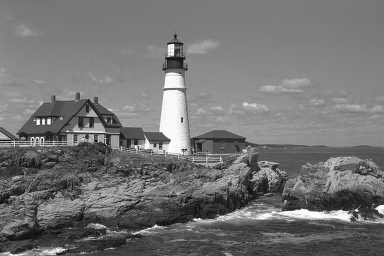

LH2
LH_resized, wymiary: (256, 384), typ danych: uint8, wartości: 7 - 255


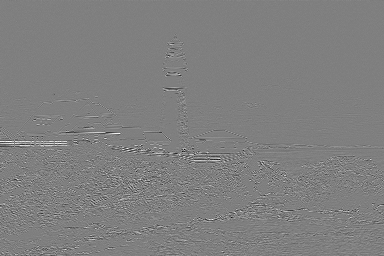

HL2
HL_resized, wymiary: (256, 384), typ danych: uint8, wartości: 21 - 255


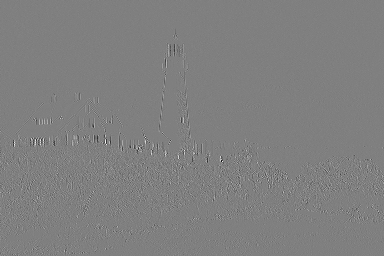

HH2
HH_resized, wymiary: (256, 384), typ danych: uint8, wartości: 0 - 241


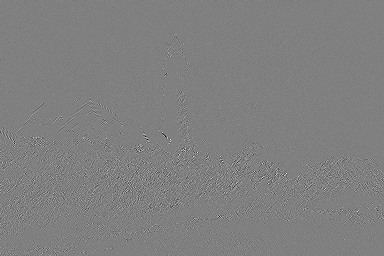

In [167]:
def resize_to_add_contrast(image):
    """
    Przeskaluj obraz na wartości z zakresu 0 - 255
    
    Skalując zachowaj zależność, że 0 będzie przeskalowane do wartości 127
    (wartość środkowa przedziału zmienności wartości pikseli)
    """
    maximum_deviation = max(image.max(), -image.min())
    image_resized = (image - image.min()).astype(np.uint32)
    image_resized = (image_resized * 128 // maximum_deviation).astype(np.uint8)

    if (maximum_deviation == image.max()):
        image_resized = image_resized + (255 - image_resized.max())
    
    return image_resized

print("LL2")
printi(ll)
show_image(ll)

# zwiększenie kontrastu obrazów 'H', żeby lepiej uwidocznić
print("LH2")
lh_resized = resize_to_add_contrast(lh)
printi(lh_resized, "LH_resized")
show_image(lh_resized)
print("HL2")
hl_resized = resize_to_add_contrast(hl)
printi(hl_resized, "HL_resized")
show_image(hl_resized)
print("HH2")
hh_resized = resize_to_add_contrast(hh)
printi(hh_resized, "HH_resized")
show_image(hh_resized)

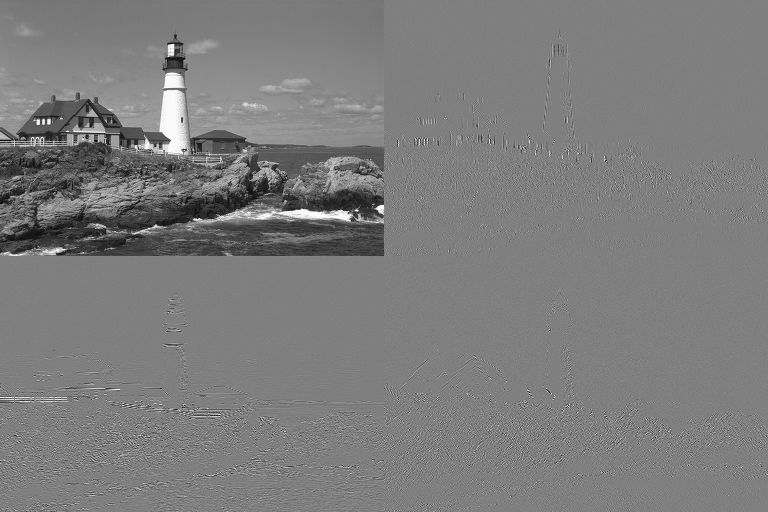

In [168]:
show_image(np.concatenate((np.concatenate((ll, lh_resized)), np.concatenate((hl_resized, hh_resized))), axis=1))

- Wyznaczyć histogramy i obliczyć entropię dla wszystkich pasm.

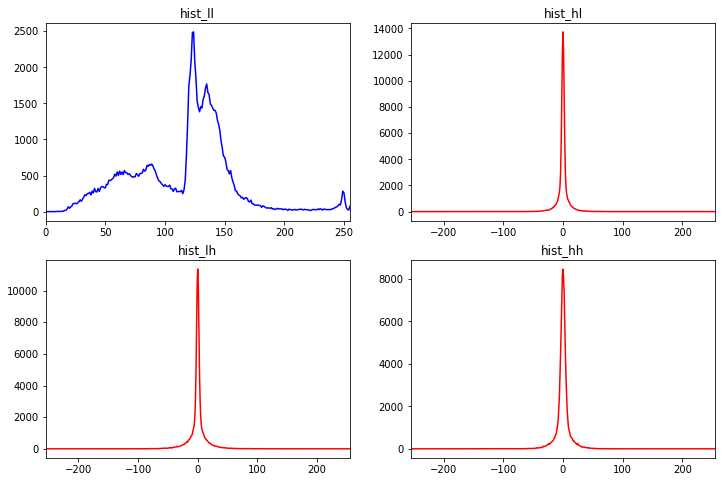

H(LL) = 7.0620 
H(LH) = 5.1162 
H(HL) = 4.5131 
H(HH) = 5.0061 
H_śr = 5.4244

H(image_mono) = 7.0398
H(hdiff) = 5.0365


In [169]:
hist_ll = generate_histogram(ll, 256)
# zmiana zakresu wartości i typu danych ze względu na cv2.calcHist() (jak wcześniej przy obrazach różnicowych)
hist_lh = generate_histogram((lh+255).astype(np.uint16), 511)
hist_hl = generate_histogram((hl+255).astype(np.uint16), 511)
hist_hh = generate_histogram((hh+255).astype(np.uint16), 511)

""" Wyświetlenie histogramów - jeden obraz z czterema pod-obrazami """
fig = plt.figure()
fig.set_figheight(fig.get_figheight()*2)  # zwiększenie rozmiarów okna
fig.set_figwidth(fig.get_figwidth()*2)
plt.subplot(2, 2, 1)
plt.plot(hist_ll, color="blue")
plt.title("hist_ll")
plt.xlim([0, 255])
plt.subplot(2, 2, 3)
plt.plot(np.arange(-255, 256, 1), hist_lh, color="red")
plt.title("hist_lh")
plt.xlim([-255, 255])
plt.subplot(2, 2, 2)
plt.plot(np.arange(-255, 256, 1), hist_hl, color="red")
plt.title("hist_hl")
plt.xlim([-255, 255])
plt.subplot(2, 2, 4)
plt.plot(np.arange(-255, 256, 1), hist_hh, color="red")
plt.title("hist_hh")
plt.xlim([-255, 255])

plt.show()  # wyświetlenie okien i oczekiwanie na ich zamnkięcie

""" Entropia dla obrazów pasmowych """
H_ll = calculate_entropy(hist_ll)
H_lh = calculate_entropy(hist_lh)
H_hl = calculate_entropy(hist_hl)
H_hh = calculate_entropy(hist_hh)

print(f"H(LL) = {H_ll:.4f} \nH(LH) = {H_lh:.4f} \nH(HL) = {H_hl:.4f} \nH(HH) = {H_hh:.4f} \nH_śr = {(H_ll + H_lh + H_hl + H_hh)/4:.4f}\n")

print(f"H(image_mono) = {H_image:.4f}")
H_hdiff = calculate_entropy(hist_hdiff)
print(f"H(hdiff) = {H_hdiff:.4f}")

> Porównać wyniki (histogram, entropia) uzyskane dla poszczególnych pasm między sobą  (czy któreś się  wyróżniają  i  dlaczego?) oraz z wynikami uzyskanymi dla obrazu oryginalnego i obrazu różnicowego.

Porównując histogramy oraz entropię najbardziej wyróżnia się pasmo LL. To pasmo niesie najwięcej informacji - przyjmuje najbardziej zróżnicowane wartości.

Wartości pozostałych pasm są skupione wokół wartości 0.

Obrazy przetworone były dwa razy (horyzontalnie i wertykalnie) odpowiednio:
- **L** - filtrem dolnoprzepustowym
- **H** - filtrem górnoprzepustowym

Filtr dolnoprzepustowy zachowuje więcej szczegółów, dlatego też obraz LL niesie najwięcej informacji.

Pasmo LL osiąga entropię zbliżoną do wartości entropii obrazu oryginalnego.

Entropia osiągana przez obraz różnicowy jest zbliżona do entropii osiąganej przez pasma LH, HL i HH.

# Obraz Barwny

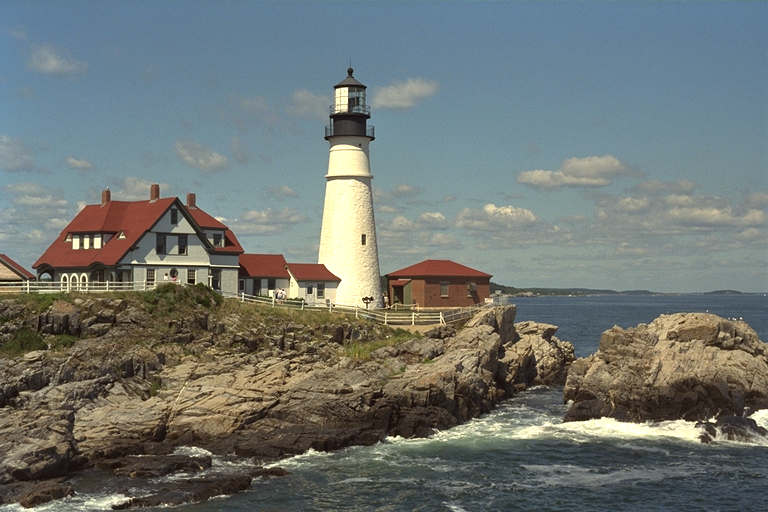

In [170]:
image_col = cv2.imread(IMAGE_COL, cv2.IMREAD_UNCHANGED)
show_image(image_col)

- Obliczyć entropię dla składowych RGB barwnego obrazu testowego.  

In [171]:
image_col = cv2.imread("./images/latarnia2_col.png")
printi(image_col, "image_col")

image_R = image_col[:, :, 2]  # cv2.imread() zwraca obrazy w formacie BGR
image_G = image_col[:, :, 1]
image_B = image_col[:, :, 0]

hist_R = generate_histogram(image_R, 256)
hist_G = generate_histogram(image_G, 256)
hist_B = generate_histogram(image_B, 256)

H_R = calculate_entropy(hist_R)
H_G = calculate_entropy(hist_G)
H_B = calculate_entropy(hist_B)
print(f"H(R) = {H_R:.4f} \nH(G) = {H_G:.4f} \nH(B) = {H_B:.4f} \nH_śr = {(H_R+H_G+H_B)/3:.4f}")


image_col, wymiary: (512, 768, 3), typ danych: uint8, wartości: 0 - 255
H(R) = 7.1159 
H(G) = 7.0730 
H(B) = 6.8653 
H_śr = 7.0181


image_R


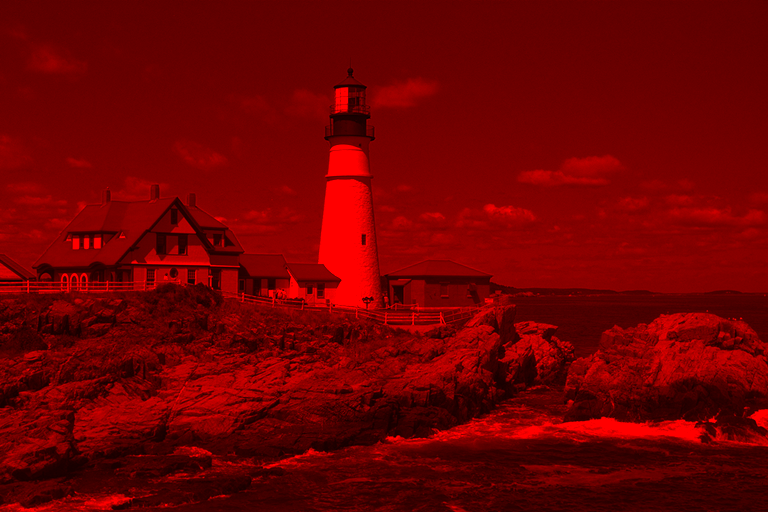

image_G


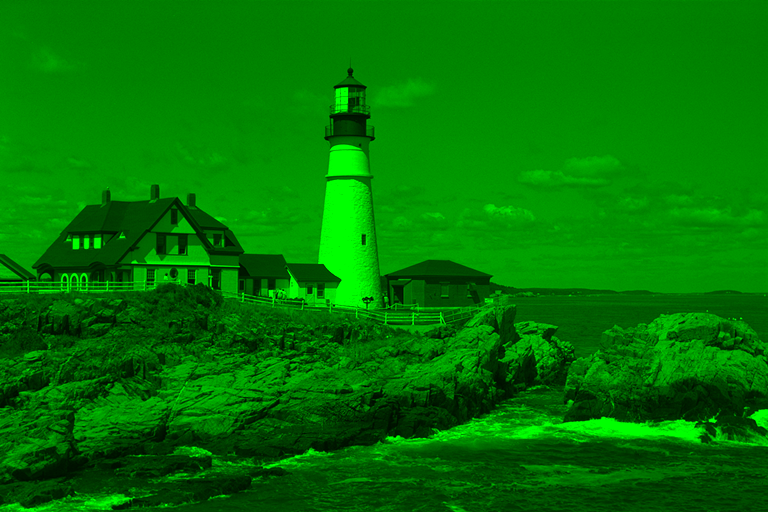

image_B


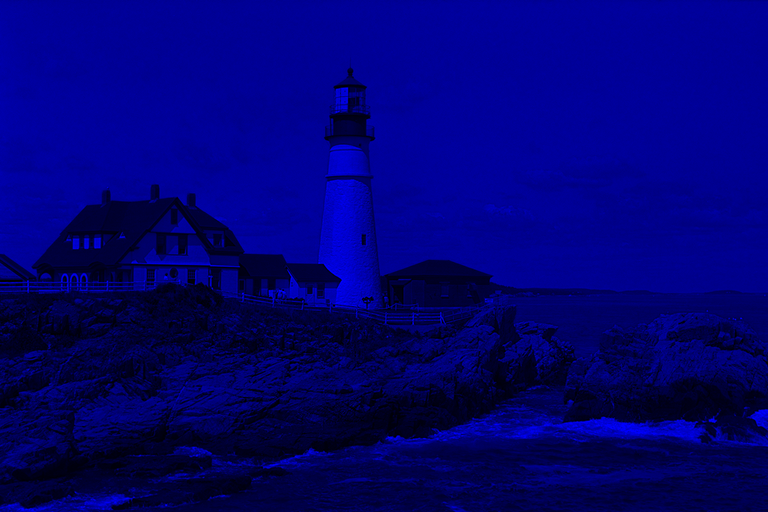

In [172]:
def extract_bgr_channel_from_image(image, color):
    image_ = np.zeros(image.shape).astype(np.uint8)
    image_[:, :, color] = image[:,:,color]
    return image_

show_image(extract_bgr_channel_from_image(image_col, 2), "image_R")
show_image(extract_bgr_channel_from_image(image_col, 1), "image_G")
show_image(extract_bgr_channel_from_image(image_col, 0), "image_B")

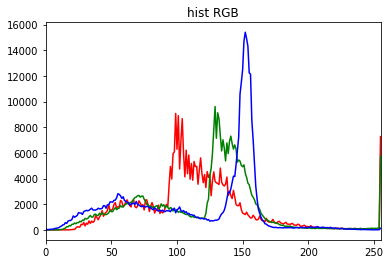

In [173]:
plt.plot(hist_R, color="red")
plt.plot(hist_G, color="green")
plt.plot(hist_B, color="blue")
plt.title("hist RGB")
plt.xlim([0, 255])
plt.show()

- Dokonać konwersji z RGB do YUV i obliczyć entropię dla składowych YUV.   

In [174]:
image_YUV = cv2.cvtColor(image_col, cv2.COLOR_BGR2YUV)
printi(image_YUV, "image_YUV")

image_Y = image_YUV[:, :, 0]
image_U = image_YUV[:, :, 1]
image_V = image_YUV[:, :, 2]

hist_Y = generate_histogram(image_Y, 256)
hist_U = generate_histogram(image_U, 256)
hist_V = generate_histogram(image_V, 256)

H_Y = calculate_entropy(hist_Y)
H_U = calculate_entropy(hist_U)
H_V = calculate_entropy(hist_V)
print(f"H(Y) = {H_Y:.4f} \nH(U) = {H_U:.4f} \nH(V) = {H_V:.4f} \nH_śr = {(H_Y+H_U+H_V)/3:.4f}")


image_YUV, wymiary: (512, 768, 3), typ danych: uint8, wartości: 3 - 255
H(Y) = 7.0083 
H(U) = 5.2929 
H(V) = 5.1524 
H_śr = 5.8179


image_Y


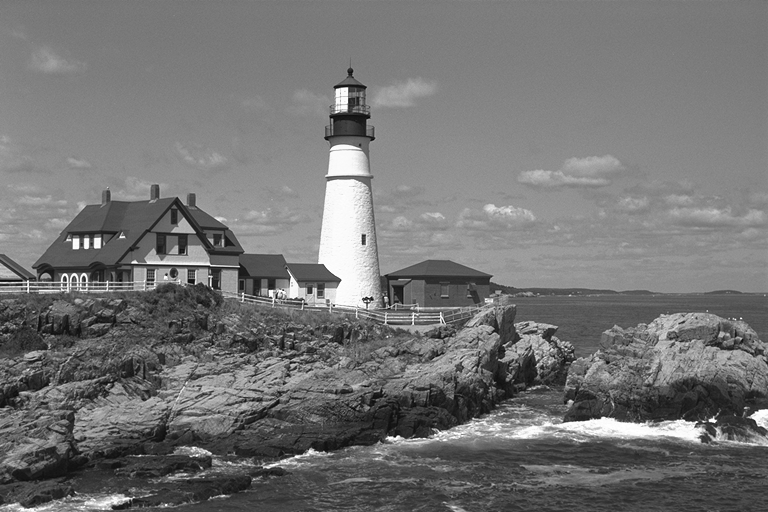

image_U


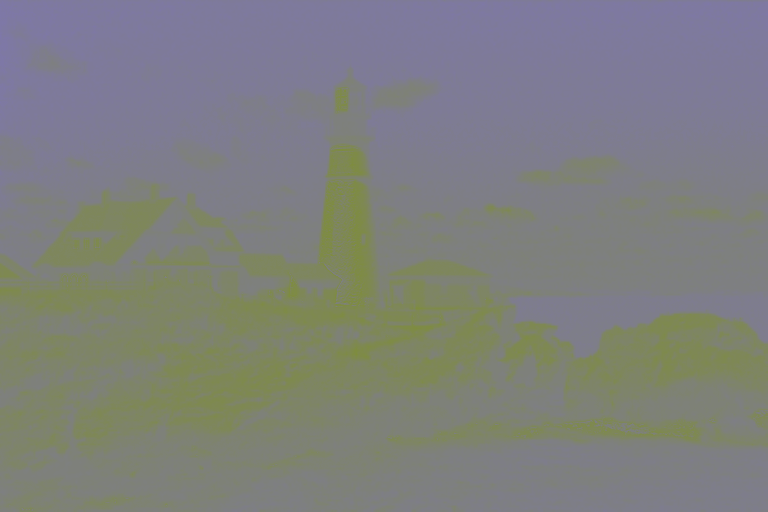

image_V


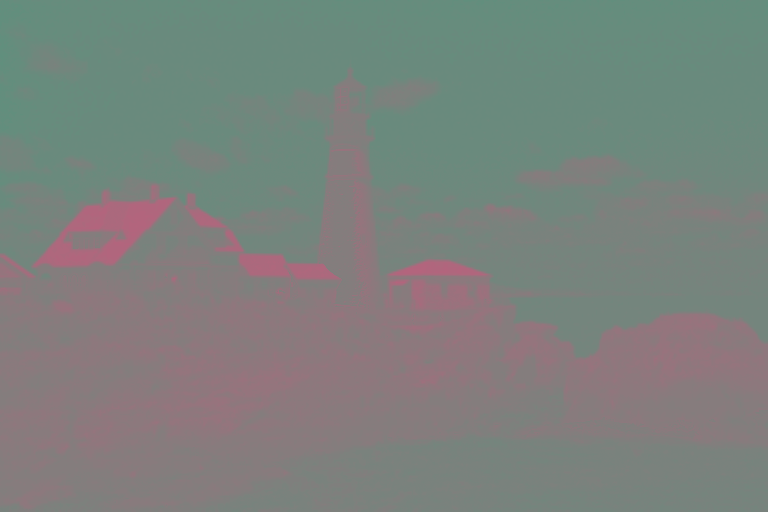

In [175]:
def extract_uv_channel_from_image_and_convert_to_bgr(image, color):
    """
    Extract U or V channel from YUV image and convert it to BGR image

    If channel is not extracted from image then the assumed default value of pixels
    in that channel (YUV) is 127 (middle value of uint8)
    """
    assert(color in [1, 2])
    
    image_ = np.full(image.shape, 127).astype(np.uint8)
    # image_[:, :, 0] = np.zeros(image[:,:,0].shape).astype(np.uint8)
    image_[:, :, color] = image[:, :, color]
    
        
    return cv2.cvtColor(image_, cv2.COLOR_YUV2BGR)

show_image(image_Y, "image_Y")
show_image(extract_uv_channel_from_image_and_convert_to_bgr(image_YUV, 1), "image_U")
show_image(extract_uv_channel_from_image_and_convert_to_bgr(image_YUV, 2), "image_V")


- Wyznaczyć histogramy dla wszystkich składowych. Porównać wyniki uzyskane dla poszczególnych składowych. Czy  dla składowych UV  entropia  jest mniejsza? Z czego ta mniejsza wartość może wynikać? 

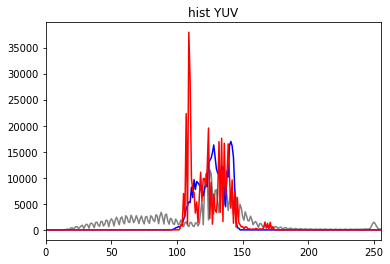

In [176]:
plt.figure()
plt.plot(hist_Y, color="gray")
plt.plot(hist_U, color="blue")
plt.plot(hist_V, color="red")
plt.title("hist YUV")
plt.xlim([0, 255])
plt.show()

> Porównać wyniki uzyskane dla poszczególnych składowych. 

Histogram składowej Y (szary) zajmuje prawie cały dostępny zakres (gdzie większość słupków jest podobnej wielkości).

Histogramy składowych UV są głównie skupione w zakresie wartości 100 - 150 (z kilkoma słupkami wyższymi niż inne).

> Czy dla składowych UV entropia jest mniejsza?

Tak, entropia dla składowych UV jest mniejsza.

> Z czego ta mniejsza wartość może wynikać? 

Mniejsza wartość wynika z wartości składowych UV skupionych w mniejszym zakresie (100 - 150).

Jest większe prawdopodobieństwo, że wartość dla danej składowej znajdzie się w zakresie bliskim 127. Tym samym zmniejsza się średnia ilość informacji płynąca z danej wartości.


- Wyznaczyć zależność zniekształcenia D od przepływności R (liczba bitów przypadającą na jeden piksel obrazu): D = f(R) – tzw. krzywa R-D – dla kodera JPEG.  

Regulacji stopnia kompresji (przepływności R) należy dokonywać ustawiając wartości parametru `quality` przy zapisie obrazu do pliku. Wartości parametru `quality` należy dobrać tak, aby uzyskać `gładkie` wykresy.

Jako miarę zniekształceń należy użyć szczytowy stosunek sygnału do szumu PSNR i błąd średniokwadratowy MSE.  

Zobrazować zależności na wykresach (oddzielny wykres dla każdej miary).

Dokonać subiektywnej oceny obrazów zrekonstruowanych (według własnej skali ocen, np.: jakość doskonała, bardzo dobra, dobra, średnia, kiepska, zła, bardzo zła, itp., lub: zniekształcenia niewidoczne, lekko widoczne, widoczne, bardzo widoczne, nie do przyjęcia, itp.) i zamieścić te oceny w sprawozdaniu (niekoniecznie dla każdego obrazu wynikowego osobno, raczej `zgrupować` oceny dla pewnych zakresów przepływności).

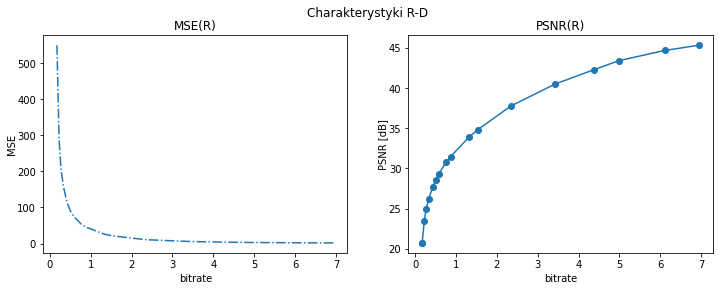

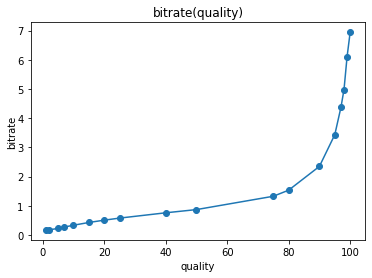

Obraz o jakości 99%, bitrate 6.106038411458333, MSE 2.226271735297309, PSNR 44.6550218831863


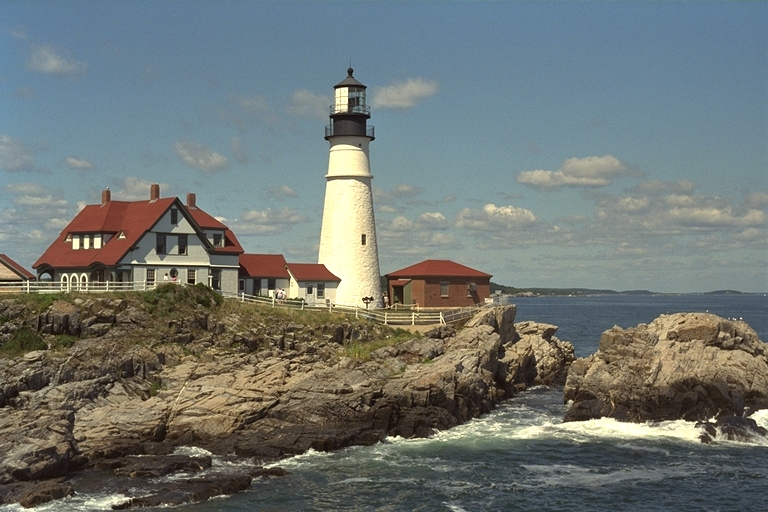

Obraz o jakości 95%, bitrate 3.4339192708333335, MSE 5.79484388563368, PSNR 40.500386203993735


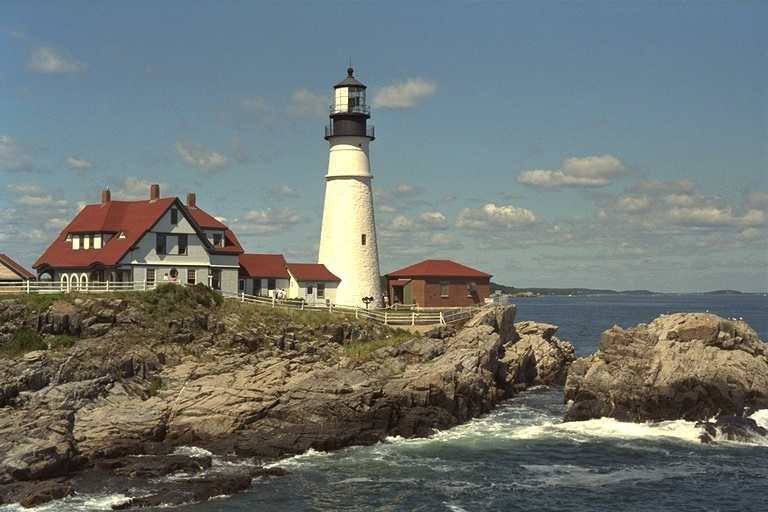

Obraz o jakości 75%, bitrate 1.3241984049479167, MSE 26.44481658935547, PSNR 33.90739801594853


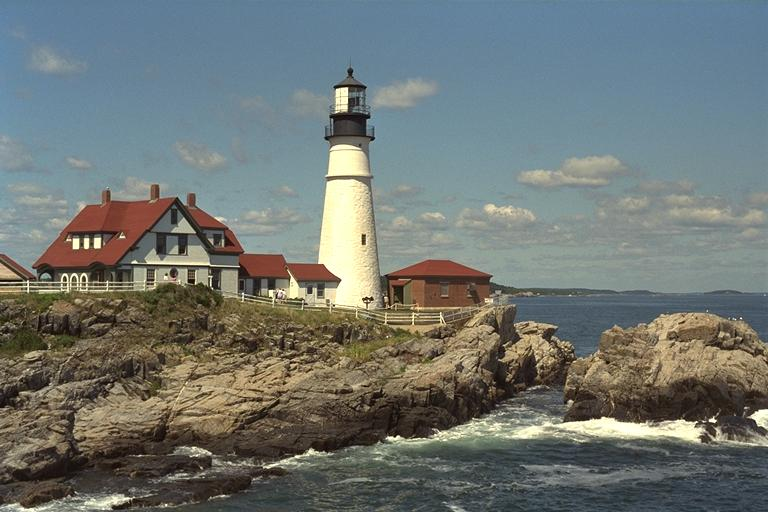

Obraz o jakości 25%, bitrate 0.5760294596354166, MSE 76.27480061848958, PSNR 29.306992797930977


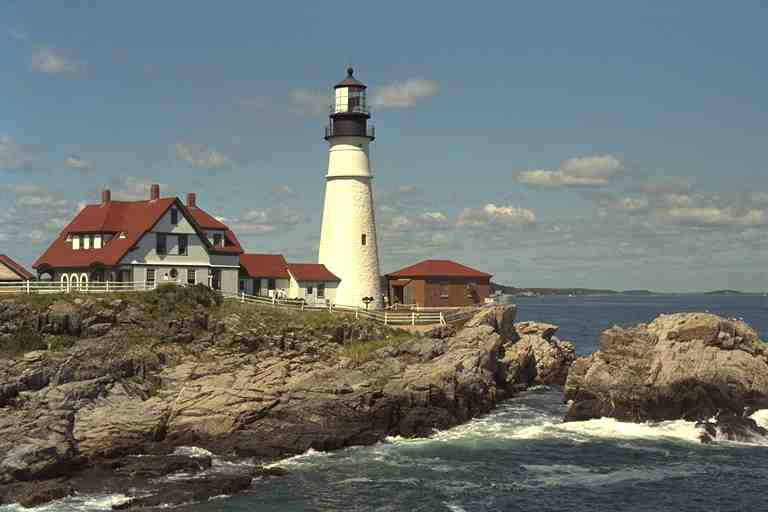

Obraz o jakości 10%, bitrate 0.3316853841145833, MSE 157.30849117702908, PSNR 26.163281953215435


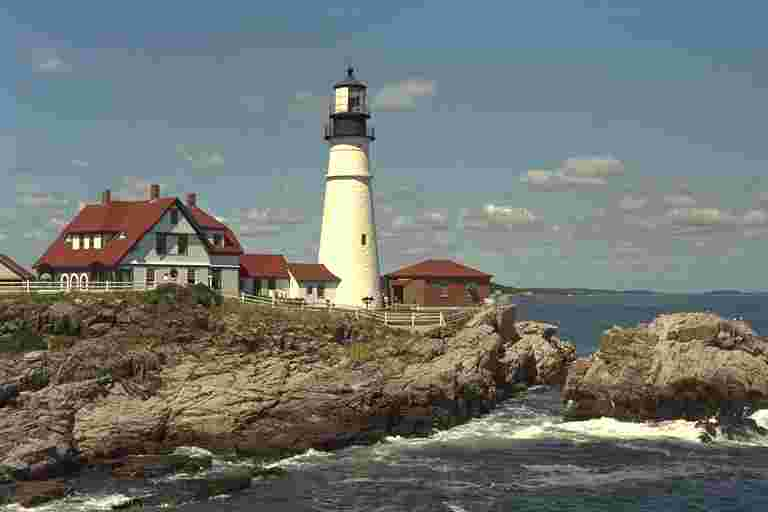

Obraz o jakości 2%, bitrate 0.17116292317708334, MSE 548.8449342515734, PSNR 20.736307007737246


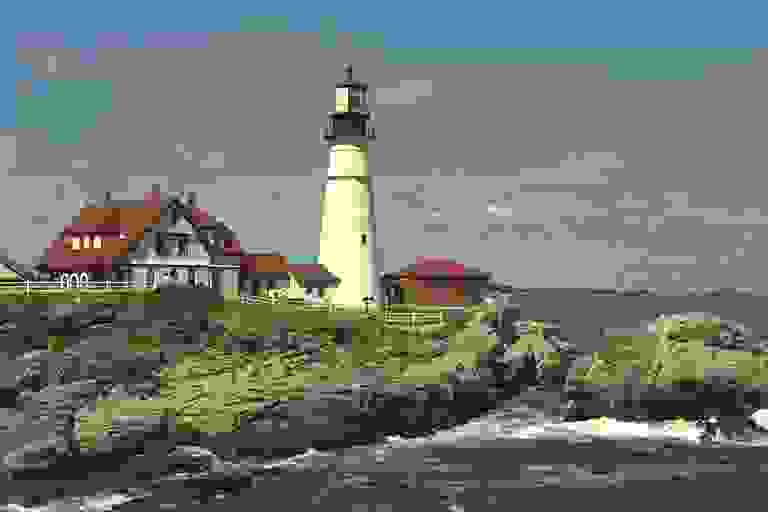

In [177]:
""" Wyznaczanie charakterystyki R-D """


def calc_mse_psnr(img1, img2):
    """ Funkcja obliczająca MSE i PSNR dla różnicy podanych obrazów, zakładana wartość pikseli z przedziału [0, 255]. """

    imax = 255.**2  # maksymalna wartość sygnału -> 255
    """
    W różnicy obrazów istotne są wartości ujemne, dlatego img1 konwertowany jest do typu np.float64 (liczby rzeczywiste)
    aby nie ograniczać wyniku do przedziału [0, 255].
    """
    mse = ((img1.astype(np.float64)-img2)**2).sum() / \
        img1.size  # img1.size - liczba elementów w img1, ==img1.shape[0]*img1.shape[1] dla obrazów mono, ==img1.shape[0]*img1.shape[1]*img1.shape[2] dla obrazów barwnych
    psnr = 10.0*np.log10(imax/mse)
    return (mse, psnr)


xx = []  # tablica na wartości osi X -> bitrate
ym = []  # tablica na wartości osi Y dla MSE
yp = []  # tablica na wartości osi Y dla PSNR

qualities = [1, 2, 5, 7, 10, 15, 20, 25, 40, 50, 75, 80, 90, 95, 97, 98, 99, 100]

# wartości dla parametru 'quality' należałoby dobrać tak, aby uzyskać 'gładkie' wykresy...
for quality in qualities:
    out_file_name = f"output/out_image_q{quality:03d}.jpg"
    """ Zapis do pliku w formacie .jpg z ustaloną 'jakością' """
    cv2.imwrite(out_file_name, image_col, (cv2.IMWRITE_JPEG_QUALITY, quality))
    """ Odczyt skompresowanego obrazu, policzenie bitrate'u i PSNR """
    image_compressed = cv2.imread(out_file_name, cv2.IMREAD_UNCHANGED)
    # image_col.shape == image_compressed.shape
    bitrate = 8*os.stat(out_file_name).st_size/(image_col.shape[0]*image_col.shape[1])
    mse, psnr = calc_mse_psnr(image_col, image_compressed)
    """ Zapamiętanie wyników do pózniejszego wykorzystania """
    xx.append(bitrate)
    ym.append(mse)
    yp.append(psnr)

""" Narysowanie wykresów """
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth()*2)
plt.suptitle("Charakterystyki R-D")
plt.subplot(1, 2, 1)
plt.plot(xx, ym, "-.")
plt.title("MSE(R)")
plt.xlabel("bitrate")
plt.ylabel("MSE", labelpad=0)
plt.subplot(1, 2, 2)
plt.plot(xx, yp, "-o")
plt.title("PSNR(R)")
plt.xlabel("bitrate")
plt.ylabel("PSNR [dB]", labelpad=0)
plt.show()

plt.plot(qualities, xx, "-o")
plt.title("bitrate(quality)")
plt.xlabel("quality")
plt.ylabel("bitrate", labelpad=0)
plt.show()


for quality in qualities[-2:0:-3]:
    i = qualities.index(quality)
    print(f"Obraz o jakości {quality}%, bitrate {xx[i]}, MSE {ym[i]}, PSNR {yp[i]}")
    display(Image(f"./output/out_image_q{quality:03d}.jpg"))

> Dokonać subiektywnej oceny obrazów zrekonstruowanych (według własnej skali ocen, np.: jakość doskonała, bardzo dobra, dobra, średnia, kiepska, zła, bardzo zła, itp., lub: zniekształcenia niewidoczne, lekko widoczne, widoczne, bardzo widoczne, nie do przyjęcia, itp.) i zamieścić te oceny w sprawozdaniu (niekoniecznie dla każdego obrazu wynikowego osobno, raczej `zgrupować` oceny 
dla pewnych zakresów przepływności).

Subiektywna jakość osiągana przez zakresy wartości:
- doskonała:
	- (3.43, 6.94]
- bardzo dobra:
	- (2.35, 3.43]
- dobra:
	- (1.3, 2.35]
- średnia:
	- (0.87, 1.3]
- kiepska:
	- (0.51, 0.87]
- zła:
	- (0.33, 0.51]
- bardzo zła:
	- (0, 0.33] 

- Porównać stopnie kompresji uzyskiwane dla kodera JPEG ze stopniem kompresji uzyskanym dla kodera PNG (pamiętając, że w pierwszej części laboratorium wykorzystywany był monochromatyczny obraz PNG, a kompresja JPEG była wykonywana dla obrazu barwnego; ewentualnie wyliczyć przepływność bitową dla obrazu barwnego skompresowanego koderem PNG).

In [178]:
png_bitrate = calculate_bitrate(IMAGE_COL)
print(f"Przepływność bitowa obrazu barwnego skompresowanego koderem PNG: {png_bitrate}")

Przepływność bitowa obrazu barwnego skompresowanego koderem PNG: 13.890360514322916


In [179]:
print(f"Rozmiar obrazu PNG: {os.stat(IMAGE_COL).st_size / 1024} KiB")
jpeg = os.stat("./output/out_image_q100.jpg").st_size / 1024
print(f"Rozmiar obrazu JPEG o quality 100%: {jpeg} KiB")

Rozmiar obrazu PNG: 666.7373046875 KiB
Rozmiar obrazu JPEG o quality 100%: 333.3232421875 KiB


In [180]:
print('Stosunek wielkości pliku PNG do pliku JPEG o jakości 100%: ', png_bitrate / xx[-1])
print('Stosunek wielkości pliku PNG do pliku JPEG o jakości 1%: ', png_bitrate / xx[0])

Stosunek wielkości pliku PNG do pliku JPEG o jakości 100%:  2.0002724691860787
Stosunek wielkości pliku PNG do pliku JPEG o jakości 1%:  81.16250594388968


> Porównać stopnie kompresji uzyskiwane dla kodera JPEG ze stopniem kompresji uzyskanym dla kodera PNG (pamiętając, że w pierwszej części laboratorium wykorzystywany był monochromatyczny obraz PNG, a kompresja JPEG była wykonywana dla obrazu barwnego; ewentualnie wyliczyć przepływność bitową dla obrazu barwnego skompresowanego koderem PNG).

Stopień kompresji uzyskany koderem JPEG jest znacznie wyższy od uzyskanego koderem PNG (od 2 do nawet 81 razy lepsza kompresja - w zależności od wymaganej jakości obrazu).

Kompresja obrazu PNG jest bezstratna, za to kompresja obrazu JPEG jest stratna.

JPEG nie zachowuje wszystkich informacji o obrazie i dlatego też nie potrzebuje aż tylu bitów, aby zapisać cały obraz.